## Gathering Data and Imports

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Installing Spark and Creating Spark session

In [3]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Time Series analysis').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=16a44f06288dc2dabb29b2606111ad00002568fa02e8c54de0e2e0d7ffec4c2e
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/03 14:29:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Loading the Train.csv Dataset into a spark DataFrame

In [4]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/train.csv')
df.limit(10).toPandas().style.hide(axis="index")

Store,Dept,Date,Weekly_Sales,IsHoliday
1,1,2010-02-05,24924.500000,False
1,1,2010-02-12,46039.490000,True
1,1,2010-02-19,41595.550000,False
1,1,2010-02-26,19403.540000,False
1,1,2010-03-05,21827.900000,False
1,1,2010-03-12,21043.390000,False
1,1,2010-03-19,22136.640000,False
1,1,2010-03-26,26229.210000,False
1,1,2010-04-02,57258.430000,False
1,1,2010-04-09,42960.910000,False


In [5]:
mn_dt = df.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = df.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',df.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  421570
Min Date:  2010-02-05
Max Date:  2012-10-26


In [6]:
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/stores.csv')
stores.limit(10).toPandas().style.hide(axis="index")

Store,Type,Size
1,A,151315
2,A,202307
3,B,37392
4,A,205863
5,B,34875
6,A,202505
7,B,70713
8,A,155078
9,B,125833
10,B,126512


In [7]:
print('Total Rows: ', stores.count())
print('Total Stores: ', stores.select('Store').distinct().count())
stores.select('Type').distinct().show()

Total Rows:  45
Total Stores:  45
+----+
|Type|
+----+
|   B|
|   C|
|   A|
+----+



In [8]:
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/features.csv')
features.limit(10).toPandas().style.hide(axis="index")

Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
1,2010-02-05,42.310000,2.572000,NA,NA,NA,NA,NA,211.0963582,8.106,False
1,2010-02-12,38.510000,2.548000,NA,NA,NA,NA,NA,211.2421698,8.106,True
1,2010-02-19,39.930000,2.514000,NA,NA,NA,NA,NA,211.2891429,8.106,False
1,2010-02-26,46.630000,2.561000,NA,NA,NA,NA,NA,211.3196429,8.106,False
1,2010-03-05,46.500000,2.625000,NA,NA,NA,NA,NA,211.3501429,8.106,False
1,2010-03-12,57.790000,2.667000,NA,NA,NA,NA,NA,211.3806429,8.106,False
1,2010-03-19,54.580000,2.720000,NA,NA,NA,NA,NA,211.215635,8.106,False
1,2010-03-26,51.450000,2.732000,NA,NA,NA,NA,NA,211.0180424,8.106,False
1,2010-04-02,62.270000,2.719000,NA,NA,NA,NA,NA,210.8204499,7.808,False
1,2010-04-09,65.860000,2.770000,NA,NA,NA,NA,NA,210.6228574,7.808,False


In [9]:
mn_dt = features.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = features.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',features.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  8190
Min Date:  2010-02-05
Max Date:  2013-07-26


## Visualizations

#### Stores Data

In [13]:
# Checking min, max, average of store by Type
stores.groupBy('Type').agg(
    f.min('Size').alias('min'), 
    f.round(f.avg('Size'),2).alias('avg'), 
    f.max('Size').alias('max')).orderBy('Type').show()

+----+-----+---------+------+
|Type|  min|      avg|   max|
+----+-----+---------+------+
|   A|39690|177247.73|219622|
|   B|34875|101190.71|140167|
|   C|39690| 40541.67| 42988|
+----+-----+---------+------+



#### Observations
- Type 'A' has the highest Average size of store
- Type 'C' has lowest Average size of store
- Type 'B' average store size is in the middle
- But the Minimun store size is close for all the store types

#### Sales Data

In [94]:
pdf = df.join(stores, on='Store', how='inner').toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size
Date,,,,,,
2010-02-05,1,1,24924.50,False,A,151315
2010-02-12,1,1,46039.49,True,A,151315
2010-02-19,1,1,41595.55,False,A,151315
2010-02-26,1,1,19403.54,False,A,151315
2010-03-05,1,1,21827.90,False,A,151315


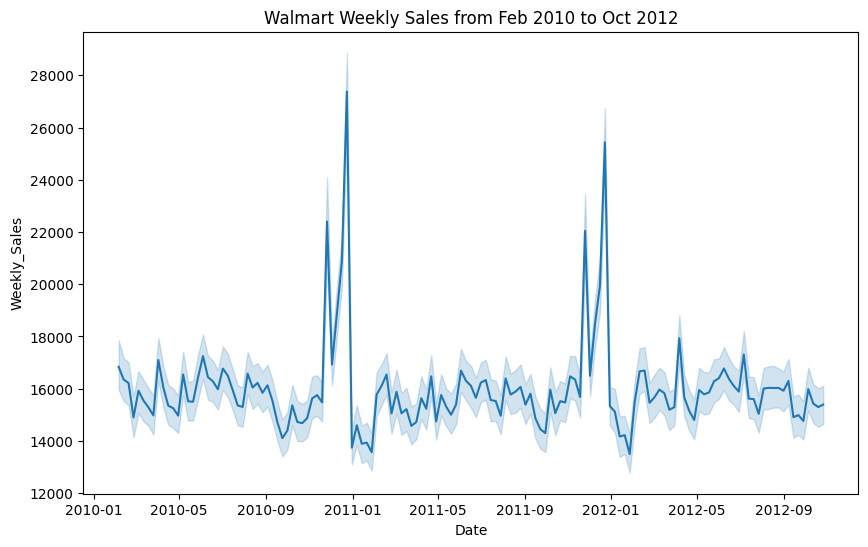

In [104]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Weekly_Sales',
            ).set_title('Walmart Weekly Sales from Feb 2010 to Oct 2012')
plt.show()

#### Observations
- We see a spike in Sales during the holiday season (November to December) every year
- The spike was highest on 2011
- Average sales moves around 16000$ for the rest of the Months

#### Taking a closer look at the Spike

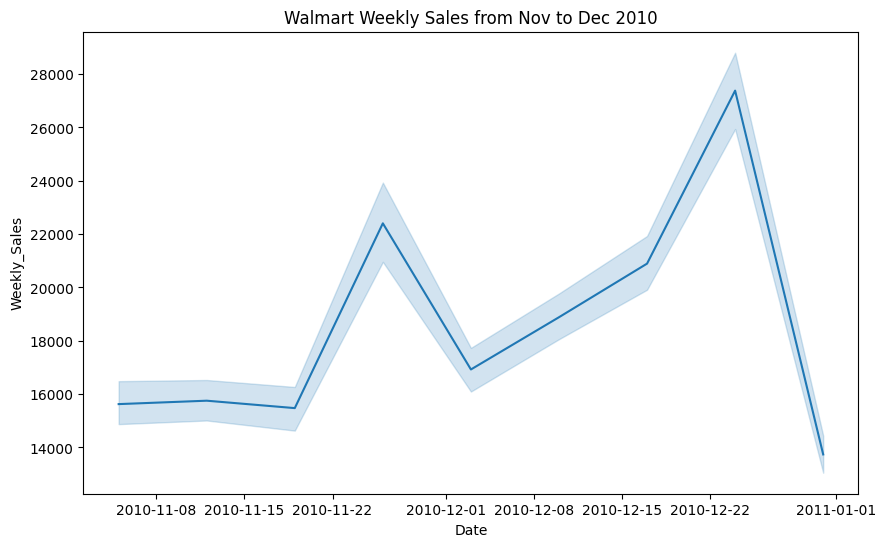

In [35]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=pdf.loc[(pdf.index >'2010-11-01') & (pdf.index<'2011-01-01')], 
    x='Date', y='Weekly_Sales'
    ).set_title('Walmart Weekly Sales from Nov to Dec 2010')
plt.show()

- The spike is seen during ThanksGiving (23-Nov) and Christmas (25-Dec)

#### Creating additional Features

In [48]:
pdf['Day'] = pdf.index.day
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year

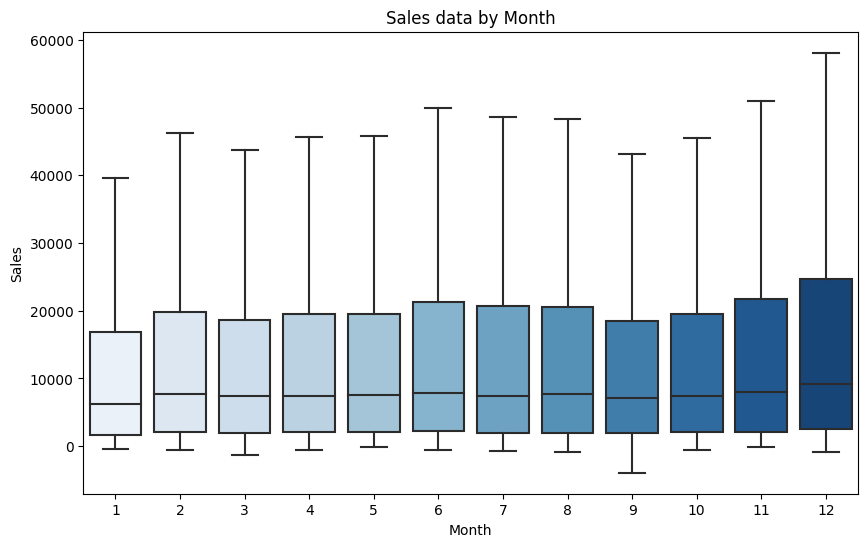

In [70]:
plt.figure(figsize=(10,6))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Month', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Month')
plt.ylabel('Sales')
plt.show()

- We can see the increase in sales in Nov(11) and December(12) 
- June(6) also has slightly higher sales

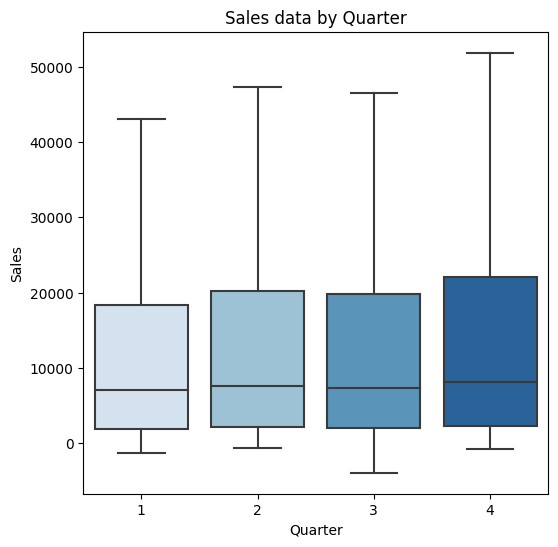

In [66]:
plt.figure(figsize=(6,6))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Quarter', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Quarter')
plt.ylabel('Sales')
plt.show()

**Q4 has the highest sales due to holiday season**

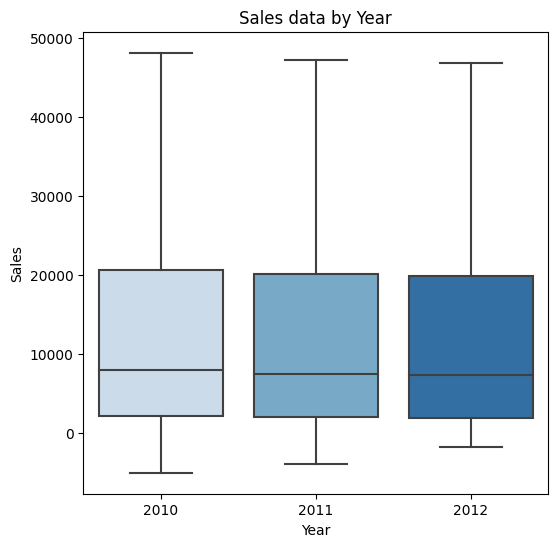

In [92]:
plt.figure(figsize=(6,6))
sns.boxplot(data=pdf, x='Year', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year')
plt.ylabel('Sales')
plt.show()

**We see a decrease in Sales from 2010 to 2012**
- Because we dont have sales of Nov and Dec in 2012
- We also dont have sales of Jan in 2010 (which might make the avg a little higher than 2011)

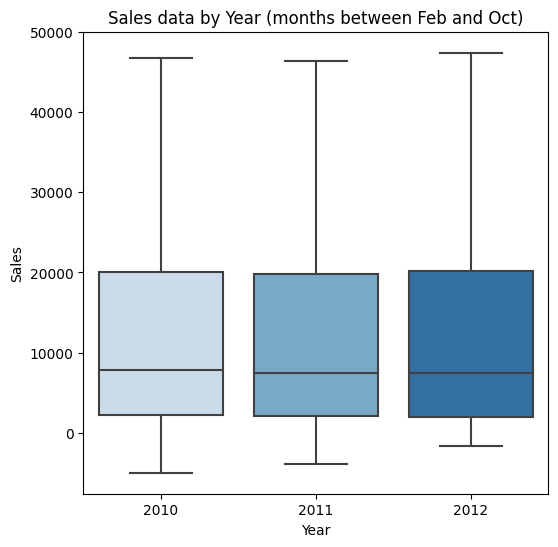

In [93]:
plt.figure(figsize=(6,6))
sns.boxplot(data=pdf.loc[pdf.index.month.isin([2,3,4,5,6,7,8,9,10])], x='Year', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year (months between Feb and Oct)')
plt.ylabel('Sales')
plt.show()


**Taking data of Months Feb-Oct as they are available for all years**
- We can see the sales is not decreasing over the years

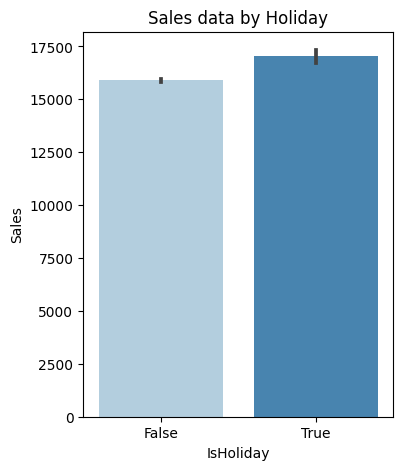

In [100]:
plt.figure(figsize=(4,5))
sns.barplot(data=pdf, x='IsHoliday', y='Weekly_Sales', 
            palette='Blues', #showfliers=False
           ).set_title('Sales data by Holiday')
plt.ylabel('Sales')
plt.show()

**Sales are slightly higher during Holidays**

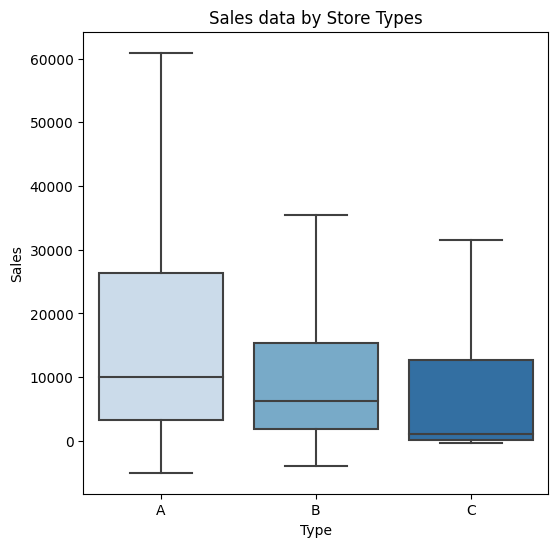

In [99]:
plt.figure(figsize=(6,6))
sns.boxplot(data=pdf, x='Type', y='Weekly_Sales', 
            palette='Blues' , showfliers=False
           ).set_title('Sales data by Store Types')
plt.ylabel('Sales')
plt.show()

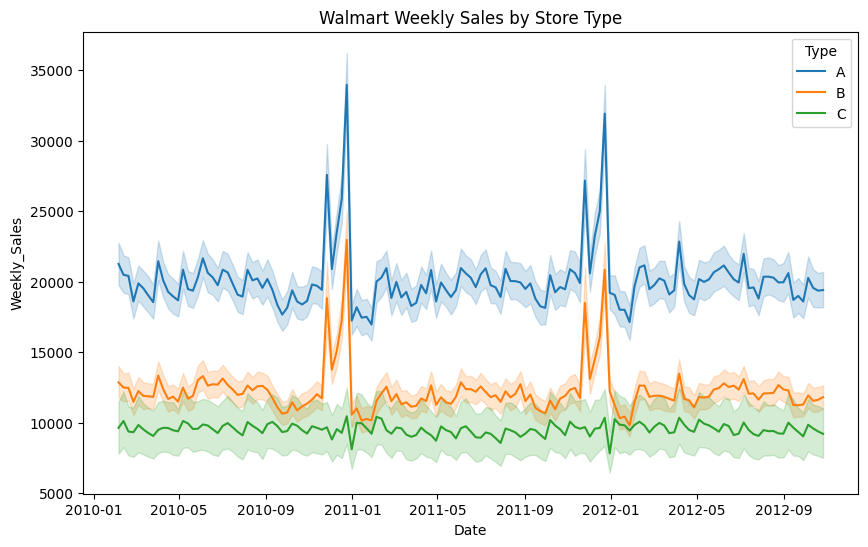

In [106]:
plt.figure(figsize=(10,6))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Weekly_Sales',
             hue='Type'
            ).set_title('Walmart Weekly Sales by Store Type')
plt.show()

**Bigger stores (A) have higher sales compared to smaller stores (B)**